<a href="https://colab.research.google.com/github/youngchul-sung/three-minutes-keras/blob/master/ex7_1_gan_dnn_prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow 2.x selected.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 1)            0         
_____

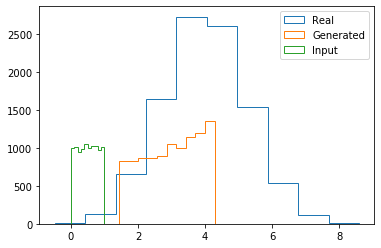

Stage 1 (Epoch: 200)
Mean and Std of Real: (3.9954760166894134, 1.25806013931934)
Mean and Std of Gen: (3.8877945, 1.1687225)


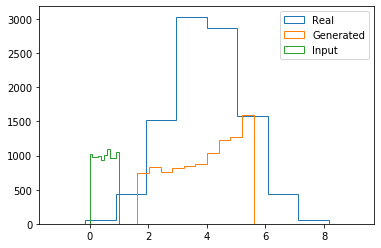

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.9996169729231696, 1.249625253438534)
Mean and Std of Gen: (3.5376227, 1.2642578)


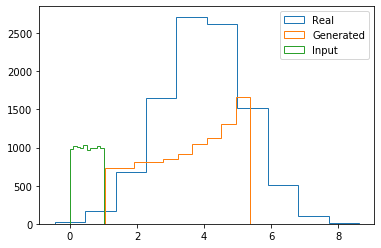

Stage 3 (Epoch: 600)
Mean and Std of Real: (4.0040029795434995, 1.2556100068775466)
Mean and Std of Gen: (5.0280614, 0.9810194)


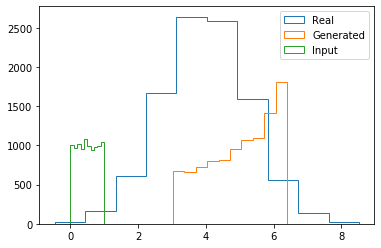

Stage 4 (Epoch: 800)
Mean and Std of Real: (3.9846470174903907, 1.262623843445819)
Mean and Std of Gen: (4.596889, 1.111035)


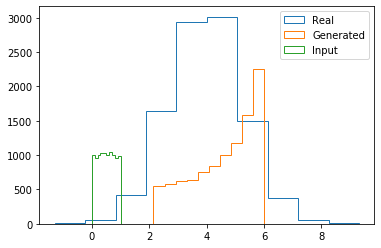

Stage 5 (Epoch: 1000)


In [0]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from tensorflow.keras import optimizers


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = keras.backend.mean(x, axis=-1, keepdims=True)
    d = keras.backend.square(x - m)
    return keras.backend.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))


lr = 2e-4  # 0.0002
adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

        self.D.summary()
        self.G.summary()
        self.GD.summary()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)


if __name__ == '__main__':
    main()